In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from numpy import linalg as LA

def LASSO_loss(X, y, theta, lamda):
    Z = - X @ theta
    N = X.shape[0]
    t=0
    for i in range(N):
        t+= np.dot(X[i], theta[:,np.argmax(y[i])])
    return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) + lamda * (LA.norm(theta))**2
#     return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) 

# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    Z = - X @ theta
    P = softmax(Z, axis=1)
    return 1/n * (X.T @ (y - P)) + 2*lamda*theta

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datam i.'''
    Z = - X[i] @ theta
    P = softmax(Z)
    X_iT= np.reshape(X[i].T,((X[i].T).shape[0],1))
    diff = y[i] - P
    diff = np.reshape(diff,(1,diff.shape[0]))
    ans= X_iT @ diff
    
    return ans+ 2*lamda*theta

def SVRG(X, y, X_test, y_test, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    test_err=[]
    theta_history = np.zeros((max_iter_inner, theta.shape[0],theta.shape[1]))

    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
#             print(k)
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
        test_err.append(1-predict(X_test,y_test, theta_hat))
        print(t)
    
    return theta_hat, theta_hat_history, loss_history, test_err

def predict(x_test, y_test, theta):
    Z= -x_test @ theta
    P = softmax(Z, axis=1)
    pred = np.argmax(P, axis=1)
    corr = np.argmax(y_test, axis=1)
    acc = sum((pred==corr).astype(np.int))/y_test.shape[0]
#     print(acc)
    return acc


# Define the function to find the mod index
def find_index(t, loop_params):
    """ finds r = min{j: 0=(m mod Prod(T_l)), 0<=j<=K}
    """
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    """ updates the reference points
    """
    updated_reference = theta_reference.copy()
    K, p, p1 = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, theta.shape[0],theta.shape[1]))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    """ updates the gradients of reference points
    """
    n = X.shape[0]
    K, p, p1 = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, theta.shape[0],theta.shape[1]))
    theta_history = []
    
    # initialization
    gradients = np.zeros((K+1, theta.shape[0],theta.shape[1]))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    # loop
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

# The SNVRG algorithm, with several one_epoch_SNVRG iterations
def SNVRG(X, y, X_test, y_test, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    test_err=[]
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
        #theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
        test_err.append(1-predict(X_test,y_test,theta_hat))
        print(t)

    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history, test_err

import random
def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

def SGD_mini(X,y, X_test, y_test, epochs, batch_size, theta, step_size, lamda):
    loss_history=[]
    test_err=[]
    for i in range(epochs):
        nBatches= int(X.shape[0]/batch_size)
        for j in range(nBatches):
            x_batch,y_batch = pack_batch(X,y,X.shape[0], batch_size)
            theta = theta- step_size*full_grad_loss(x_batch,y_batch,theta, lamda)
            
        test_err.append(1-predict(X_test,y_test,theta))
        loss_history.append(LASSO_loss(X, y, theta, lamda))
        print(i)
    return loss_history, test_err

        
# def SGD(X,y,epochs, theta, step_size, X_test, y_test):
#     for i in range(epochs):
#         for j in range(X.shape[0]):
#             n = random.randint(0,X.shape[0]-1)
#             theta = theta- step_size*grad(X,y,theta, 0.01, n)
        
#         predict(X_test,y_test,theta)
        
def subset_idx(data, classes):
    idx=[]
    for i in range(data.shape[0]):
        if data[i] in classes:
            idx.append(i)
    return idx

def subset_classes_data(x_train, y_train, x_test, y_test, classes):
    # Subset 'plane' and 'car' classes to perform logistic regression

    idx_train = subset_idx(y_train, classes)
    idx_test = subset_idx(y_test, classes)
    
    x_train = x_train[idx_train, :]
    y_train = y_train[idx_train]

    x_test = x_test[idx_test, :]
    y_test = y_test[idx_test]
    
    return x_train, y_train, x_test, y_test




In [25]:
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

train_raw = loadmat('svhn_data/train_32x32')
test_raw = loadmat('svhn_data/test_32x32')

x_train = np.array(train_raw['X'])
x_test = np.array(test_raw['X'])

y_train = train_raw['y']
y_test = test_raw['y']


x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

x_train = np.reshape(x_train, (x_train.shape[0], 32*32*3))
x_test = np.reshape(x_test, (x_test.shape[0], 32*32*3))

x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

x_train /= 255.0
x_test /= 255.0

y_train = y_train[:,0]
y_test = y_test[:,0]

classes=[0,1,2,3,4]
x_train, y_train,x_test, y_test= subset_classes_data(x_train, y_train, x_test, y_test, classes)

y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))

# lb = LabelBinarizer()
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

In [26]:
theta = np.zeros((3072,len(classes)))
epochs=20
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history, svrg_test_err = SVRG(x_train, y_train,x_test, y_test, theta, lamda=0, max_iter=epochs, 
                                                                max_iter_inner=100, step_size=0.001)

<ipython-input-2-79adf2c1612c>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [27]:
epochs=20
theta = np.zeros((3072,len(classes)))
# loop_params = [100,100,100,100,100,100,100,100,100,100]
loop_params= [2,2]
base_batch_size = x_train.shape[0]
# batch_params = [1,1,1,1,1,1,1,1,1,1]
batch_params=[128,64]
step_size = 0.01
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history, snvrg_test_err = SNVRG(x_train, y_train, x_test, y_test, theta, 0, epochs, loop_params, batch_params, base_batch_size, step_size)
# snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(x_train, y_train, theta, 0.1, 5, loop_params, batch_params, base_batch_size, step_size)

<ipython-input-2-79adf2c1612c>:12: RuntimeWarning: overflow encountered in exp
  return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) + lamda * (LA.norm(theta))**2
<ipython-input-2-79adf2c1612c>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [32]:
theta = np.zeros((3072,len(classes)))
epochs=100
SGD_loss_history, SGD_test_err = SGD_mini(x_train, y_train,x_test, y_test, epochs, 1000,theta, 0.05,  0)


<ipython-input-2-79adf2c1612c>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


No handles with labels found to put in legend.


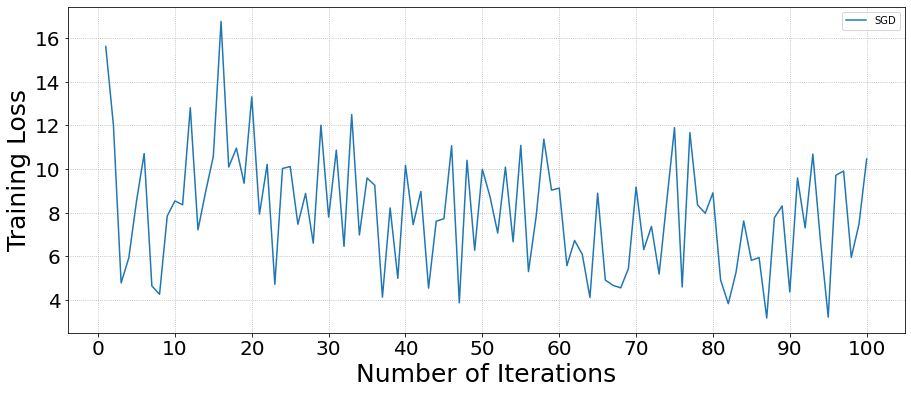

No handles with labels found to put in legend.


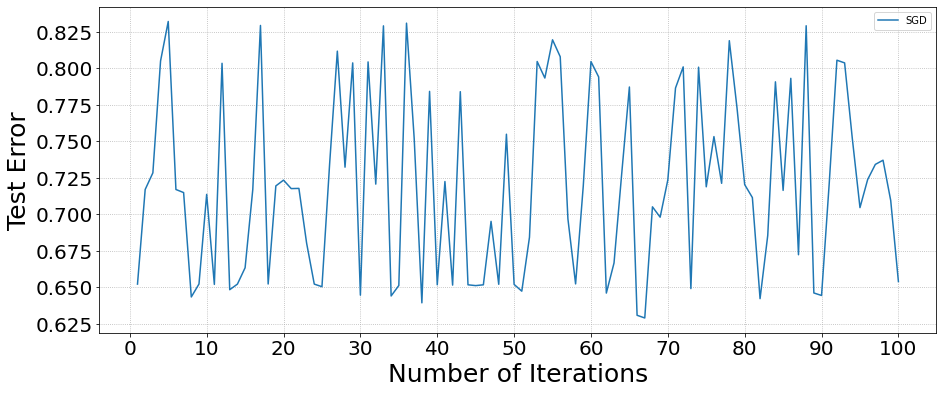

In [33]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
# plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_loss_history,  label ="SGD")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
# plt.plot(np.arange(1,epochs+1,1), snvrg_test_err, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), svrg_test_err, label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_test_err, label = "SGD")
plt.legend()
plt.show()


In [22]:
snvrg_loss_history

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]